In [54]:
import numpy as np
from sklearn.datasets import load_svmlight_file
# import urllib.request
# import random
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD, Adam

torch.set_default_dtype(torch.float64)

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [56]:
# np.random.seed(0)
n = 1000
# d = 119
# A = np.random.randn(n,d)
# xopt = np.random.randn(d)
# b=np.dot(A,xopt)
# tA = torch.Tensor(A)
# tb = torch.Tensor(b)
# xopt = torch.Tensor(xopt)

In [57]:
def NLLSQ(w,X,y):
    return torch.mean(torch.square(y-1/(1+torch.exp(-X@w))))

In [58]:
def logreg(w, X, y):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))

def grad_logreg(w, X, y):
    r = torch.exp(-y * (X @ w))
    return ( (r/(1 + r)) @ (X * -y[:, None]) ) / X.shape[0]

def hess_logreg(w, X, y):
    r = torch.exp(-y * (X @ w))
    return ( X.T @ (  (r/torch.square(1 + r)).reshape(-1, 1) * X ) ) / X.shape[0]

In [59]:
# !wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms

--2023-10-16 19:12:54--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879712 (859K)
Saving to: ‘mushrooms’

mushrooms           100%[===================>] 859.09K   961KB/s    in 0.9s    

2023-10-16 19:12:55 (961 KB/s) - ‘mushrooms’ saved [879712/879712]



In [30]:
# load_svmlight_file()

In [60]:
dataset_name = "mushrooms"
batch_size = 64

# dataset_url = f"https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/{dataset_name}"
# dataset_src = urllib.request.urlopen(dataset_url)
trainX, trainY = load_svmlight_file(dataset_name)


In [61]:

train_data = torch.Tensor(np.array(trainX.toarray()))
train_target = torch.Tensor(trainY)
train_target

tensor([1., 2., 2.,  ..., 2., 1., 2.])

In [62]:
train_load = TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=False)


In [63]:
scale = 1
r1 = -scale
r2 = scale

scaling_vec = (r1 - r2) * torch.rand(train_data.shape[1]) + r2

scaling_vec = torch.pow(torch.e, scaling_vec).reshape([1,-1])

train_data_scaled = train_data * scaling_vec

train_data.shape, scaling_vec.shape, train_data.dtype, scaling_vec.dtype


(torch.Size([8124, 112]), torch.Size([1, 112]), torch.float64, torch.float64)

In [64]:




train_load_scaled = TensorDataset(train_data_scaled, train_target)
train_dataloader_scaled = DataLoader(train_load_scaled, batch_size=batch_size, shuffle=False)

def fun(At,x,bt):
    return 1/2*torch.mean(torch.norm(At@x-bt)**2)

def dfun(At,x,bt):
    return At.T@(At@x-bt)

def hessfun(At,x,bt):
    H=1/n*At.T@At

loss_function = NLLSQ
loss_grad = dfun
loss_hessian = hessfun



if loss_function == NLLSQ:
    train_target[train_target == train_target.unique()[0]] = torch.tensor(0.0, dtype=torch.get_default_dtype())
    train_target[train_target == train_target.unique()[1]] = torch.tensor(1.0, dtype=torch.get_default_dtype())
    assert torch.equal(train_target.unique(), torch.tensor([0.0, 1.0]))


In [65]:
s_v=scaling_vec

In [66]:
def rademacher_old(weights):
    return torch.round(torch.rand_like(weights)) * 2 - 1

def diag_estimate_old(weights, grad, iters):
    Ds = []
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.append((hvp*z))

    return torch.mean(torch.stack(Ds), 0)

def run_psps2(train_data, train_target, train_dataloader, epochs, precond_method="cg", **kwargs):

    torch.manual_seed(0)

    # parameters
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

    # save loss and grad size to history
    hist = []


    loss = loss_function(w, train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    f_grad = g.clone().detach()


    if precond_method == "none":
        D = torch.ones_like(w)
    elif precond_method == "hutch":
        alpha=0.1
        beta=0.999
        init_iters = kwargs["hutch_init_iters"]
        Dk = diag_estimate_old(w, g, init_iters)
    elif precond_method == "cg" or precond_method == "pcg":
        s = torch.zeros_like(w) # s = H_inv * grad
        r = f_grad - torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
        p = r.detach().clone()
        r_prev = torch.dot(r, r)
        MAX_ITER = train_data.shape[1] * 2
        # MAX_ITER = 1000

    elif precond_method == "scaling_vec":
        scaling_vec = kwargs["scaling_vec"]
        D = (1 / scaling_vec)**2
    elif precond_method == "adam" or precond_method == "adam_m":
        D = torch.zeros_like(g)
        v = torch.zeros_like(g)
        step_t = torch.tensor(0.)
        betas = (0.9, 0.999)
    elif precond_method == "adagrad" or precond_method == "adagrad_m":
        D = torch.zeros_like(g)
        v = torch.zeros_like(g)

    pcg_method = kwargs.get("pcg_method")
    if pcg_method == "hutch":
        alpha=0.1
        beta=0.999
        init_iters = kwargs["hutch_init_iters"]
        Dk_pcg = diag_estimate_old(w, g, init_iters)
    elif pcg_method == "adam":
        D_pcg = torch.zeros_like(g)
        v_pcg = torch.zeros_like(g)
        step_t_pcg = torch.tensor(0.)
        betas = (0.9, 0.999)
    elif pcg_method == "adagrad":
        D_pcg = torch.zeros_like(g)
        v_pcg = torch.zeros_like(g)
    elif pcg_method == None:
        D_pcg = torch.ones_like(g)

    cg_steps = []

    for epoch in range(epochs):

        loss = loss_function(w, train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        grad_norm_sq = torch.linalg.norm(g) ** 2
        acc = (np.sign(train_data @ w.detach().numpy()) == train_target).sum() / train_target.shape[0]

        # print(f"[{epoch}/{epochs}] | Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()} | Accuracy: {acc}")
        # hist.append([loss.item(), grad_norm_sq.item(), acc])

        for i, (batch_data, batch_target) in enumerate(train_dataloader):

            loss = loss_function(w, batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.detach().clone()

            # ssstep = 1.0

            if i % 64 == 0:
                loss = loss_function(w, train_data.to(device), train_target.to(device))
                g, = torch.autograd.grad(loss, w, create_graph=True)
                grad_norm_sq = torch.linalg.norm(g) ** 2
                print(f"[{epoch}][{i}] | Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()} | Accuracy: {acc}")
                hist.append([loss.item(), grad_norm_sq.item(), acc])

            if precond_method == "hess_diag":
                hess = loss_hessian(w, batch_data, batch_target)
                hess_diag_inv = 1 / torch.diag(hess)
                s = hess_diag_inv * f_grad

            elif precond_method == "scaling_vec":
                s = D * f_grad

            elif precond_method == "adam" or precond_method == "adam_m":
                step_t += 1
                v = betas[1] * v + (1 - betas[1]) * g.square()
                v_hat = v / (1 - torch.pow(betas[1], step_t))

                if precond_method == "adam":
                    D = 1 / (torch.sqrt(v_hat) + 1e-6)
                elif precond_method == "adam_m":
                    D = 1 / (v_hat ) # NO SQRT ADAM
                s = D * f_grad

            elif precond_method == "adagrad" or precond_method == "adagrad_m":
                v.add_(torch.square(g))
                if precond_method == "adagrad":
                    D = 1 / (torch.sqrt(v) + 1e-6)
                elif precond_method == "adagrad_m":
                    D = 1 / (v + 1e-6) # NO SQRT ADAGRAD
                s = D * f_grad

            elif precond_method == "none":
                s = D * f_grad

            elif precond_method == "hutch":
                vk = diag_estimate_old(w, g, 1)

                # Smoothing and Truncation
                Dk = beta * Dk + (1 - beta) * vk
                Dk_hat = torch.abs(Dk)
                Dk_hat[Dk_hat < alpha] = alpha

                D = 1 / Dk_hat
                s = D * f_grad

            elif precond_method == "cg":


                # estimate the TR radius from Polyak-step-size
                trDelta = (loss / ( f_grad.dot(f_grad) )).item()
                # print("trDelta",trDelta)


                gamma=0.999

                # CG is here
                s = torch.zeros_like(w) # s = H_inv * grad
                z = torch.zeros_like(w)
                r = f_grad.clone()
                p = r.clone()
                # tt=f_grad.clone()
                for cg_step in range(MAX_ITER):
                    hvp = torch.autograd.grad(g, w, grad_outputs=p, retain_graph=True)[0]

                    # print(torch.dot(p,hvp))
                    if torch.dot(p,hvp)<=0: 
                        # print("NEGATIVE CURVATURE")
                        # if torch.dot(p,f_grad)<=0:
                        s=gamma*z*torch.sign(torch.dot(z,f_grad))+(1-gamma)*p*torch.sign(torch.dot(p,f_grad))
                        # else:
                            # s=-p
                        # hvs = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
                        # ssstep=torch.dot(s,f_grad)/torch.dot(s,hvs)
                        step_size=torch.min(torch.tensor([loss/torch.dot(s,s),50]))
                        # print("*")
                        break



                    # print(">",cg_step)
                    # print(">",torch.dot(p,hvp))
                    alpha_k = torch.dot(r, r) / torch.dot(p, hvp)
                    z = z + alpha_k * p
                    r_prev = r.clone()
                    r = r - alpha_k * hvp
                    if torch.norm(r) < 1e-4:
                        s=z
                        # hvs = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
    
                        # Ax = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
                        # diff = torch.norm(Ax - f_grad)
                        # print(f"CG Took {cg_step} to reach diff={diff}")
                        # cg_steps.append(cg_step)
                        grad_norm_sq_scaled = torch.dot(f_grad, s)
                        if 2 * loss <= grad_norm_sq_scaled:
                            c = loss / ( grad_norm_sq_scaled )
                            det = 1 - 2 * c
                            if det < 0.0:
                                step_size = 1.0
                            else:
                                # print("**")
                                step_size = 1 - torch.sqrt(det)
                        else:
                            # print(f"[{epoch}, {i}] No solution")
                            # print("***")
                            step_size = 1.0
                        
                        
                        break

                    beta_k = torch.dot(r, r) / torch.dot(r_prev, r_prev)
                    p = r + beta_k * p


            # elif precond_method == "pcg":

            #     if pcg_method == "hutch":
            #         vk_pcg = diag_estimate_old(w, g, 1)
            #         # Smoothing and Truncation
            #         Dk_pcg = beta * Dk_pcg + (1 - beta) * vk_pcg
            #         Dk_hat = torch.abs(Dk_pcg)
            #         Dk_hat[Dk_hat < alpha] = alpha
            #         D_pcg = 1 / Dk_hat
            #     elif pcg_method == "adam":
            #         step_t_pcg += 1
            #         v_pcg = betas[1] * v_pcg + (1 - betas[1]) * f_grad.square()
            #         v_hat = v_pcg / (1 - torch.pow(betas[1], step_t_pcg))
            #         D_pcg = 1 / (torch.sqrt(v_hat) + 1e-6)
            #     elif pcg_method == "adagrad":
            #         v_pcg.add_(f_grad.square())
            #         D_pcg = 1 / (torch.sqrt(v_pcg) + 1e-6)
            #     elif pcg_method == "none":
            #         D_pcg = torch.ones_like(f_grad)

                # # hess = loss_hessian(w, batch_data, batch_target)
                # # hess_diag_inv = 1 / torch.diag(hess)

                # hess_diag_inv = D_pcg.clone()
                # # Preconditioned CG is here
                # s = torch.zeros_like(w) # s = H_inv * grad
                # r = f_grad.clone()
                # z = hess_diag_inv * r
                # p = z.detach().clone()

                # for cg_step in range(MAX_ITER):
                #     hvp = torch.autograd.grad(g, w, grad_outputs=p, retain_graph=True)[0]
                #     alpha_k = torch.dot(r, z) / torch.dot(p, hvp)
                #     s = s + alpha_k * p
                #     r_prev = r.clone()
                #     r = r - alpha_k * hvp
                #     if torch.norm(r) < 1e-6:
                #         Ax = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
                #         diff = torch.norm(Ax - f_grad)
                #         print(f"PCG Took {cg_step} to reach diff={diff}")
                #         cg_steps.append(cg_step)
                #         break

                #     z_prev = z.clone()
                    # z = hess_diag_inv * r
                    # beta_k = torch.dot(r, z) / torch.dot(r_prev, z_prev)
                    # p = z + beta_k * p


            

            step_size = step_size
            # print("step_size",step_size)
            # FB =  loss_function(w, train_data.to(device), train_target.to(device))
            # FBB =  loss_function(w, batch_data, batch_target)
            with torch.no_grad():
                w.sub_(step_size *s)
            # FA =  loss_function(w, train_data.to(device), train_target.to(device))
            # FAA =  loss_function(w, batch_data, batch_target)
            
            # print(FA - FB, " <<< 0", FAA - FBB)
            # if i > 50:
            #   return ''

    return hist
EPOCHS = 100
hist_cg = run_psps2(train_data, train_target, train_dataloader, EPOCHS, precond_method="cg")

[0][0] | Loss: 0.25 | GradNorm^2: 0.07989174018857569 | Accuracy: 0.48202855736090594
[0][64] | Loss: 0.40379812227901596 | GradNorm^2: 0.02168482652807983 | Accuracy: 0.48202855736090594
[1][0] | Loss: 0.18635222601656207 | GradNorm^2: 0.010426571952247887 | Accuracy: 0.507754800590842
[1][64] | Loss: 0.24430445634681167 | GradNorm^2: 0.004781334398935615 | Accuracy: 0.507754800590842
[2][0] | Loss: 0.06872807613040968 | GradNorm^2: 0.003122701225970912 | Accuracy: 0.5073855243722304
[2][64] | Loss: 0.07400414150516689 | GradNorm^2: 0.003391055875152924 | Accuracy: 0.5073855243722304
[3][0] | Loss: 0.05997381741463587 | GradNorm^2: 0.0004631103448305735 | Accuracy: 0.5076317085179715
[3][64] | Loss: 0.059057796459009264 | GradNorm^2: 0.00028256104395425454 | Accuracy: 0.5076317085179715
[4][0] | Loss: 0.05977346744954284 | GradNorm^2: 0.0002485965053509538 | Accuracy: 0.507754800590842
[4][64] | Loss: 0.05988166872063343 | GradNorm^2: 0.00014711480812000296 | Accuracy: 0.5077548005908

In [126]:
# hist_cg_scaled = run_psps2(train_data_scaled, train_target, train_dataloader_scaled, EPOCHS, precond_method="cg")

[0][0] | Loss: 0.25 | GradNorm^2: 0.11660138013696598 | Accuracy: 0.48202855736090594
[0][64] | Loss: 0.4488360204094503 | GradNorm^2: 5.399834550729768e-05 | Accuracy: 0.48202855736090594
[1][0] | Loss: 0.4487680474515415 | GradNorm^2: 5.863394809781286e-05 | Accuracy: 0.517971442639094
[1][64] | Loss: 0.45008028986906584 | GradNorm^2: 3.382738834333269e-06 | Accuracy: 0.517971442639094
[2][0] | Loss: 0.4500761152705862 | GradNorm^2: 3.449845201469049e-06 | Accuracy: 0.517971442639094
[2][64] | Loss: 0.45038096995685667 | GradNorm^2: 3.037855966082365e-07 | Accuracy: 0.517971442639094
[3][0] | Loss: 0.45038059259971575 | GradNorm^2: 3.054766957660512e-07 | Accuracy: 0.517971442639094
[3][64] | Loss: 0.45046204622199537 | GradNorm^2: 4.914322540459135e-08 | Accuracy: 0.517971442639094
[4][0] | Loss: 0.4504619846517015 | GradNorm^2: 4.925206898329163e-08 | Accuracy: 0.517971442639094
[4][64] | Loss: 0.4504904843744045 | GradNorm^2: 1.2151838309575588e-08 | Accuracy: 0.517971442639094
[5

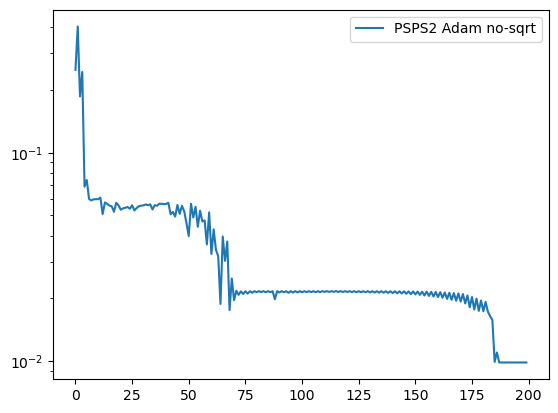

In [67]:
plt.semilogy([x[0] for x in hist_cg], label="PSPS2 Adam no-sqrt")
# plt.semilogy([x[0] for x in hist_cg_scaled], linestyle="--", label="PSPS2 Adam no-sqrt (scaled data)")

plt.legend()

In [ ]:
hist_adam_m = run_psps2(train_data, train_target, train_dataloader, EPOCHS, precond_method="adam_m")

[0/100] | Loss: 1.285942885278188 | GradNorm^2: 2.780539152370406 | Accuracy: 0.0


UnboundLocalError: local variable 'ssstep' referenced before assignment

In [ ]:
hist_adam_m_scaled = run_psps2(train_data_scaled, train_target, train_dataloader_scaled, EPOCHS, precond_method="adam_m")

[0/200] | Loss: 7134.183037412288 | GradNorm^2: 4189665362.3540506 | Accuracy: 0.0
[1/200] | Loss: 36726.765757789035 | GradNorm^2: 1731976887.294416 | Accuracy: 0.0
[2/200] | Loss: 32063.635434853688 | GradNorm^2: 665986914.1063794 | Accuracy: 0.0
[3/200] | Loss: 28555.169649375475 | GradNorm^2: 377413930.9972227 | Accuracy: 0.0
[4/200] | Loss: 25517.848310782654 | GradNorm^2: 280204745.7776257 | Accuracy: 0.0
[5/200] | Loss: 22723.56487405939 | GradNorm^2: 242272671.79482 | Accuracy: 0.0
[6/200] | Loss: 20113.091900933923 | GradNorm^2: 227474952.8862337 | Accuracy: 0.0
[7/200] | Loss: 17675.875692176352 | GradNorm^2: 222315568.92573893 | Accuracy: 0.0
[8/200] | Loss: 15411.763980316704 | GradNorm^2: 220669571.07369027 | Accuracy: 0.0
[9/200] | Loss: 13321.741689323635 | GradNorm^2: 219633153.3077289 | Accuracy: 0.0
[10/200] | Loss: 11406.186677310367 | GradNorm^2: 217846624.34642026 | Accuracy: 0.0
[11/200] | Loss: 9664.571265361486 | GradNorm^2: 214659458.95667353 | Accuracy: 0.0
[1

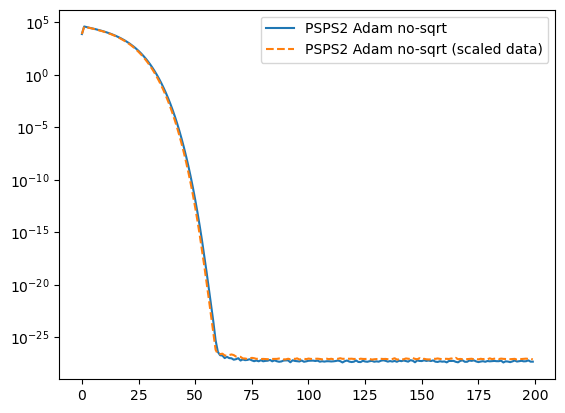

In [ ]:
plt.semilogy([x[0] for x in hist_adam_m], label="PSPS2 Adam no-sqrt")
plt.semilogy([x[0] for x in hist_adam_m_scaled], linestyle="--", label="PSPS2 Adam no-sqrt (scaled data)")

plt.legend()